**Version 5**: Added web interface.

<hr>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

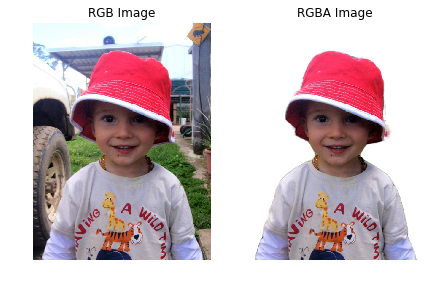

In [2]:
# set up the canvas for the subplots
plt.figure(figsize=(7,7))
plt.tight_layout()
plt.axis('Off')


# Our subplot will contain 4 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)

# image
plt.subplot(1,2,1)
path = '../input/matting_human_half/clip_img/1803281053/clip_00000000/1803281053-00000348.jpg'
image = plt.imread(path)
plt.title('RGB Image')
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,2,2)
path = '../input/matting_human_half/matting/1803281053/matting_00000000/1803281053-00000348.png'
mask = plt.imread(path)
plt.title('RGBA Image')
plt.imshow(mask)
plt.axis('off')

plt.show()

## Introduction

**Objective**

Given a half-length portrait image of one person, build a model that can separate the person from the background.

**Approach**

- Use a Keras U-Net model architecture.
- Resize all training images to 128x128.
- Use only 4000 images for training.
- Use generators and chunking to reduce RAM usage and prevent the kernel from crashing.
- Set aside 100 images to test the model.

**Dataset Info**

- 24,479 RGB images in jpg format - shape: (600, 800, 3)
- 24,479 RGBA images in png format - shape: (600, 800, 4)
- One corrupt RGB image ( ._1803241125-00000005.jpg )

RGB images have 3 channels. But RGBA images have 4 channels. The 4th channel controls the pixel transparency. It's called the alpha channel. This channel has values between 0 and 255. 0 is transparent. 255 is opaque. We can add a 4th channel to any RGB image. We can then vary the transparency of any pixel on that image by changing the values on the 4th channel. 

We will train the model using RGB images. The ground truth (target) is the 4th channel of the RGBA images. Therefore, we will need to extract this 4th channel.

**Web Interface**

I've deployed the model as a tensorflow.js web app. You can submit a photo and get a segmented output. 

Web App:<br>
http://selfieseg.test.woza.work/<br>
Github:<br>
https://github.com/vbookshelf/V1-Selfie-Segmenter

The quality of the output segmentation is not very good. One reason is because the model was trained using only 4,000 images. My main purpose for building the app was to understand the workflow involved in building an end-to-end web based solution that ouputs an image. The same workflow can also be used for other fun machine learning applications like style transfer. Or on a more serious note, imagine having a freely available tool like this that could take as input the photo of a missing child and output an aged photo. The javascript, html and css code for the app is available on github.

Okay, let's start by putting all file names into dataframes and taking a look at one image.

<hr>

In [3]:
NUM_TEST_IMAGES = 100

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

BATCH_SIZE = 100

SAMPLE_SIZE = 4000

### Get image info

In [4]:
# ==========================
# 1. Get folder and file info

# image_id
# folder_id
# type (image or matt)


folder_list = os.listdir('../input/matting_human_half/clip_img')

for i, folder_id in enumerate(folder_list):
    
    if i == 0:
        
        # get a list of images in that folder
        path = '../input/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/'
        image_list = os.listdir(path)

        df = pd.DataFrame(image_list, columns=['image_id'])

        df['folder_id'] = folder_id
        
        df['num_images_in_folder'] = len(image_list)

        df['type'] = 'image'
        
        df_img = df
    

    else:
        
        # get a list of images in that folder
        path = '../input/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/'
        image_list = os.listdir(path)

        df_1 = pd.DataFrame(image_list, columns=['image_id'])

        df_1['folder_id'] = folder_id
        
        df_1['num_images_in_folder'] = len(image_list)
        

        df_1['type'] = 'image'
       
        # concat the dataframes
        df_img = pd.concat([df_img, df_1], axis=0).reset_index(drop=True)

        
# remove a corrupt file
df_img = df_img[df_img['image_id'] != '._1803241125-00000005.jpg']

# reset the index
df_img = df_img.reset_index(drop=True)



df_img.head()

,image_id,folder_id,num_images_in_folder,type
0,1803261926-00000305.jpg,1803261926,195,image
1,1803261926-00000308.jpg,1803261926,195,image
2,1803261926-00000434.jpg,1803261926,195,image
3,1803261926-00000106.jpg,1803261926,195,image
4,1803261926-00000188.jpg,1803261926,195,image


### Get mask info

In [5]:

# 1. Get folder and file info

# image_id
# folder_id
# type (image or matt)


folder_list = os.listdir('../input/matting_human_half/matting/')

for j, folder_id in enumerate(folder_list):
    
    if j == 0:
        
        # get a list of images in that folder
        path = '../input/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/'
        image_list = os.listdir(path)

        df = pd.DataFrame(image_list, columns=['mask_id'])

        df['folder_id'] = folder_id
        
        df['num_images_in_folder'] = len(image_list)

        df['type'] = 'mask'
    
        df_msk = df
        
    else:
        
        # get a list of images in that folder
        path = '../input/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/'
        image_list = os.listdir(path)

        df_1 = pd.DataFrame(image_list, columns=['mask_id'])

        df_1['folder_id'] = folder_id

        df_1['type'] = 'mask'
    
        # concat the dataframes
        df_msk = pd.concat([df_msk, df_1], axis=0).reset_index(drop=True)


df_msk.head()

,folder_id,mask_id,num_images_in_folder,type
0,1803261926,1803261926-00000367.png,195.0,mask
1,1803261926,1803261926-00000292.png,195.0,mask
2,1803261926,1803261926-00000366.png,195.0,mask
3,1803261926,1803261926-00000175.png,195.0,mask
4,1803261926,1803261926-00000317.png,195.0,mask


In [6]:
print('Num Images: ', df_img.shape[0])
print('Num Masks: ', df_msk.shape[0])

Num Images:  24479
Num Masks:  24479


### Create a merged dataframe

We are merging dataframes to ensure that the order of the images and masks is the same i.e. an image and its mask are on the same row. 

In [7]:

# We will use this column to merge df_images and df_masks.

def get_name(x):
    
    name = x.split('.')[0]
    
    return name

df_img['merge_col'] = df_img['image_id'].apply(get_name)

df_msk['merge_col'] = df_msk['mask_id'].apply(get_name)

df_data = pd.merge(df_img, df_msk, on='merge_col')

# select only specific columns
df_data = df_data[['image_id', 'mask_id']]

In [8]:
df_data.tail()

,image_id,mask_id
24474,1803242036-00000368.jpg,1803242036-00000368.png
24475,1803242036-00000288.jpg,1803242036-00000288.png
24476,1803242036-00000270.jpg,1803242036-00000270.png
24477,1803242036-00000049.jpg,1803242036-00000049.png
24478,1803242036-00000158.jpg,1803242036-00000158.png


### Take a look at one image and it's alpha channel

(800, 600, 3)


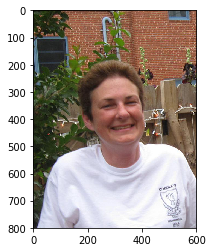

In [9]:
# Image

path = '../input/matting_human_half/clip_img/1803242036/clip_00000000/1803242036-00000058.jpg'

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

plt.show()

(800, 600, 3)


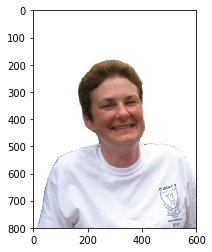

In [10]:
# Mask

path = '../input/matting_human_half/matting/1803242036/matting_00000000/1803242036-00000058.png'

matt = plt.imread(path)

print(image.shape)

plt.imshow(matt)

plt.show()

#### Extract the alpha channel

The alpha channel is the 4th channel in an RGBA image. It controls pixel transparency. 0 is fully transparent and 255 is opaque. Setting a value between 0 and 255 varies the transparency.

(800, 600, 4)


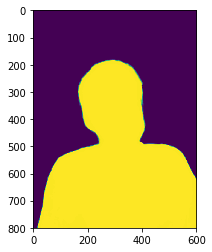

In [11]:
# alpha channel

# If we don't use cv2.IMREAD_UNCHANGED then the image will be read with only 3 channels.
rgba_image = cv2.imread(path, cv2.IMREAD_UNCHANGED) 

# select the 4th channel
alpha = rgba_image[:,:,3]

print(rgba_image.shape)

plt.imshow(alpha)

plt.show()

## Create a test set

We will create a test set consisting of 100 images.

In [12]:
# create a test set
df_test = df_data.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_data = df_data[~df_data['image_id'].isin(test_images_list)]

print(df_data.shape)
print(df_test.shape)

(24379, 2)
(100, 2)


## Train Test Split

In [13]:
# train_test_split

# Reduce the number of rows of df_data to speed up training.
# Choose a random sample of rows.
df_data = df_data.sample(SAMPLE_SIZE, random_state=101)

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101)


# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3400, 2)
(600, 2)
(100, 2)


### Save the dataframes as compressed csv files

Having csv files will allow us to use Pandas chunking to feed images into the generators. Compression is very helpful when working with huge datasets because there's only 4.9GB of disk space available in the Kaggle kernel.

In [14]:
# save the dataframes as a compressed csv files

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)
df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [15]:
# check if the files were saved
!ls

__notebook__.ipynb  df_test.csv.gz   df_val.csv.gz
__output__.json     df_train.csv.gz


## Build the Data Generators

The ouput from a generator does not accumulate in memory. Each output batch overwrites the last one. This means that we can feed large amounts of data into a model without running out of RAM and crashing the kernel. There's a 13GB RAM limit when using a GPU.

We will use Pandas chunking and the compressed csv files to feed data into the generators. Using chunking simplifies the code. For example, the last batch that is fed into a generator will be smaller than the others. Pandas chunking will handle this change in batch size automatically which means that we won't need to write code to handle this condition.

Chunking is very useful when the csv file data is too large to be loaded into memory i.e. into a single Pandas dataframe.

### [ 1 ] Train Generator

In [16]:
def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            # get a list of masks
            mask_id_list = list(df['mask_id'])
            
            # Create empty X matrix - 3 channels
            # Note: We use len(df) because the last batch will be smaller than the other batches.
            X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_train
            #================
            
            for i, image_id in enumerate(image_id_list):
                
                # select the folder_id from the list
                folder_id = image_id.split('-')[0]

                # set the path to the image
                path = '../input/matting_human_half/clip_img/' + str(folder_id) + \
                '/clip_00000000/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_train
                X_train[i] = image
            
            
            # Create Y_train
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):
                
                # select the folder_id from the list
                folder_id = mask_id.split('-')[0]

                # set the path to the mask
                path = '../input/matting_human_half/matting/' + str(folder_id) + \
                '/matting_00000000/' + mask_id

                # read the image
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

                # select the alpha channel
                mask = mask[:, :, 3]
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                # resize the mask
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into Y_train
                Y_train[j] = mask

            yield X_train, Y_train

### Sanity check the train generator

In [17]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=100)

In [18]:
# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(100, 128, 128, 3)
(100, 128, 128, 1)


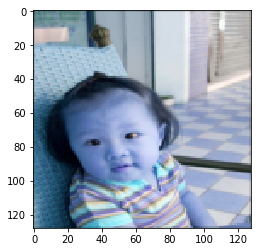

In [19]:
# print the first image in X_train

img = X_train[1,:,:,:]
plt.imshow(img)

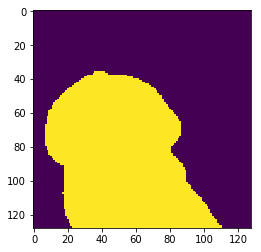

In [20]:
# print the first mask in Y_train

msk = Y_train[1,:,:,0]
plt.imshow(msk)

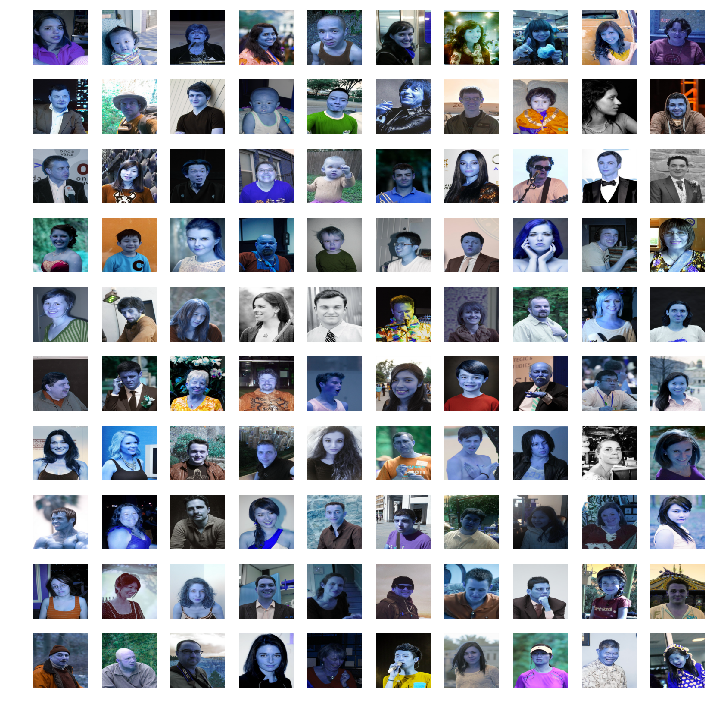

In [21]:
# Display the generator output - X_train

# X_train

n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(X_train[i,:,:,:], cmap=plt.cm.gray)
    ax.axis('off')

plt.tight_layout()
plt.show()

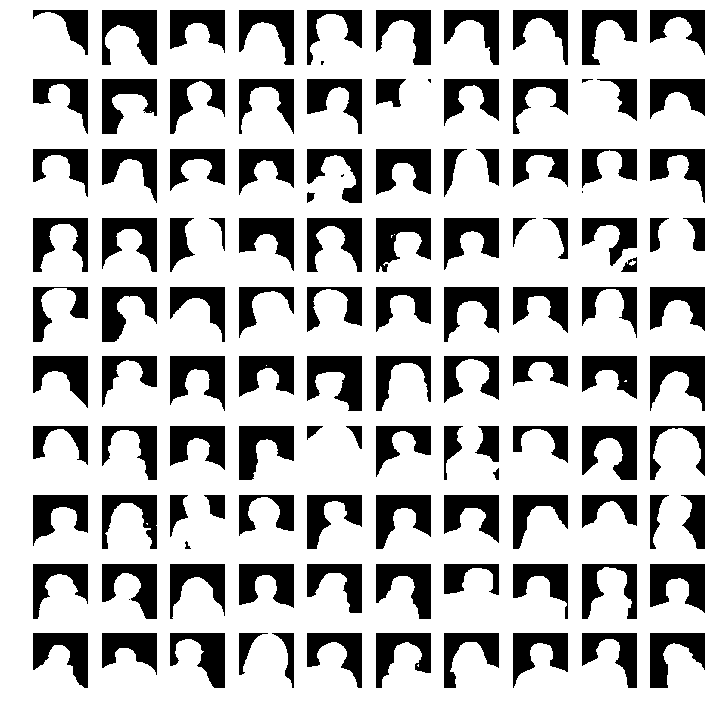

In [22]:
# Display the generator output - Y_train

# Y_train

n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(Y_train[i,:,:,0], cmap=plt.cm.gray)
    ax.axis('off')

plt.tight_layout()
plt.show()

### [ 2 ] Val Generator

In [23]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            # get a list of masks
            mask_id_list = list(df['mask_id'])
            
            # Create empty X matrix - 3 channels.
            # Note: We use len(df) because the last batch will be smaller than the other batches.
            X_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                
                # select the folder_id from the list
                folder_id = image_id.split('-')[0]

                # set the path to the image
                path = '../input/matting_human_half/clip_img/' + str(folder_id) + \
                '/clip_00000000/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_val
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):
                
                # select the folder_id from the list
                folder_id = mask_id.split('-')[0]

                # set the path to the mask
                path = '../input/matting_human_half/matting/' + str(folder_id) + \
                '/matting_00000000/' + mask_id

                # read the image
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

                # select the alpha channel
                mask = mask[:, :, 3]
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                # resize the mask
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into Y_val
                Y_val[j] = mask

            yield X_val, Y_val

### Sanity check the val generator

In [24]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

In [25]:
# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 128, 128, 3)
(10, 128, 128, 1)


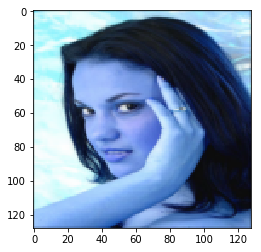

In [26]:
# print the first image in X_val

img = X_val[1,:,:,:]
plt.imshow(img)

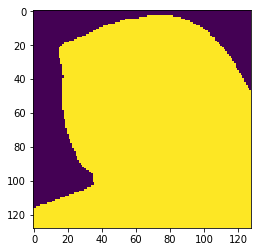

In [27]:
# print the first mask in Y_val

msk = Y_val[1,:,:,0]
plt.imshow(msk)

### [ 3 ] Test Generator

In [28]:
def test_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels.
            # Note: We use len(df) because the last batch will be smaller than the other batches.
            X_test = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            

            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                
                # select the folder_id from the list
                folder_id = image_id.split('-')[0]

                # set the path to the image
                path = '../input/matting_human_half/clip_img/' + str(folder_id) + \
                '/clip_00000000/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_test
                X_test[i] = image
            

            yield X_test

### Sanity check the test generator

In [29]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=10)

In [30]:
# run the generator
X_test = next(test_gen)

print(X_test.shape)

(10, 128, 128, 3)


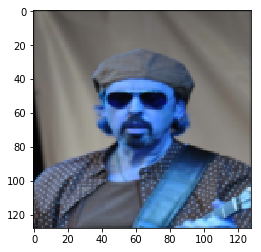

In [31]:
# print the first image in X_test

img = X_test[1,:,:,:]
plt.imshow(img)

## Create X_test

In [32]:
# Here we will use the test generator with a batch size of 1 to create X_test

# initialize
test_gen = test_generator(batch_size=len(df_test))
# run the generator
X_test = next(test_gen)

X_test.shape

(100, 128, 128, 3)

## Create X_test_orig - original 800x600 size

Here we will create a numpy matrix containing the test images in their original 800x600 size.

In [33]:

# get the list of images
test_id_list = list(df_test['image_id'])

# Create empty X matrix - 3 channels.
# Note: We use len(df) because the last batch will be smaller than the other batches.
X_test_orig = np.zeros((len(df_test), 800, 600, 3), dtype=np.uint8)


# Create X_test
#================

for i, image_id in enumerate(test_id_list):

    # select the folder_id from the list
    folder_id = image_id.split('-')[0]

    # set the path to the image
    path = '../input/matting_human_half/clip_img/' + str(folder_id) + \
    '/clip_00000000/' + image_id

    # read the image using skimage
    image = cv2.imread(path)

    # insert the image into X_train
    X_test_orig[i] = image
    
    
    
X_test_orig.shape

(100, 800, 600, 3)

## Model Architecture

In [34]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [35]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# normalize the images
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

## Train the Model

In [36]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [37]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)


filepath = "model.h5"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
34/34 [==============================] - 467s 14s/step - loss: 0.5122 - val_loss: 0.3787

Epoch 00001: val_loss improved from inf to 0.37873, saving model to model.h5
Epoch 2/20
34/34 [==============================] - 395s 12s/step - loss: 0.2784 - val_loss: 0.2573

Epoch 00002: val_loss improved from 0.37873 to 0.25729, saving model to model.h5
Epoch 3/20
34/34 [==============================] - 420s 12s/step - loss: 0.2333 - val_loss: 0.2423

Epoch 00003: val_loss improved from 0.25729 to 0.24232, saving model to model.h5
Epoch 4/20
34/34 [==============================] - 425s 13s/step - loss: 0.2013 - val_loss: 0.1925

Epoch 00004: val_loss improved from 0.24232 to 0.19250, saving model to model.h5
Epoch 5/20
34/34 [==============================] - 412s 12s/step - loss: 0.1657 - val_loss: 0.1772

Epoch 00005: val_loss improved from 0.19250 to 0.17723, saving model to model.h5
Epoch 6/20
34/34 [============================

## Make a Prediction

In [38]:
# Make a prediction
# Note that we have a lambda layer in the model to normalize the images.

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights(filepath = 'model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

100/100 [==============================] - 17s 173ms/step


In [39]:
predictions.shape

(100, 128, 128, 1)

## Process the predictions

### Resize the predictions

In order to maintain the image sharpness we need to append the alpha channel to the orginal 800x600 images i.e. images that were never resized. This is because a resized image loses its sharpness. Before we can append the predcited alpha channel to an original image we need to resize it from 128x128 to 800x600.

In [40]:

# get the list of images
test_id_list = list(df_test['image_id'])


for i, image_id in enumerate(test_id_list):
    
    if i == 0:
        
        # get a predicted mask
        image = predictions[i]

        # resize
        preds = resize(image, (800, 600))
        
        # reshape
        preds = preds.reshape((1, 800, 600, 1))
    
    else:

        # get a predicted mask
        image = predictions[i]
        
        # resize
        image = resize(image, (800, 600))
        
        # reshape
        image = image.reshape((1, 800, 600, 1))

        # stack the images
        preds = np.vstack((preds, image))


preds.shape

(100, 800, 600, 1)

### Threshold the predictions

The predictions are actually probabilities that a pixel is either part of the person or part of the background. Here we threshold the predictions to convert all values to either 1 or 0.

In [41]:
# Threshold the predictions

preds_test_thresh = (preds >= 0.5).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


### Change values from 0/1 to 0/255

An alpha channel must have values between 0 and 255.

In [42]:
# simply multiply by 255
alpha_preds = preds_test_thresh * 255

print(alpha_preds.min())
print(alpha_preds.max())

0
255


In [43]:
print(X_test_orig.shape)
print(alpha_preds.shape)

(100, 800, 600, 3)
(100, 800, 600, 1)


### Concat the predicted alpha channels to the original test images

Concatenate alpha_preds to X_test_orig along the channel axis. X_test_orig will then have 4 channels. The 4th channel is the predicted masks with values either 0 or 255.

Remember that the 4th channel controls the transparency of each pixel.

In [44]:
# concat
predicted_masks = np.concatenate((X_test_orig, alpha_preds), axis=-1)

predicted_masks.shape

(100, 800, 600, 4)

## Display some results

Notice that the predicted images have the same sharpness has the original images. Overall the results look quite good considering that we used only 4000 training images. U-Net was designed for medical applications but it appears that it's also very good at segmenting selfies.

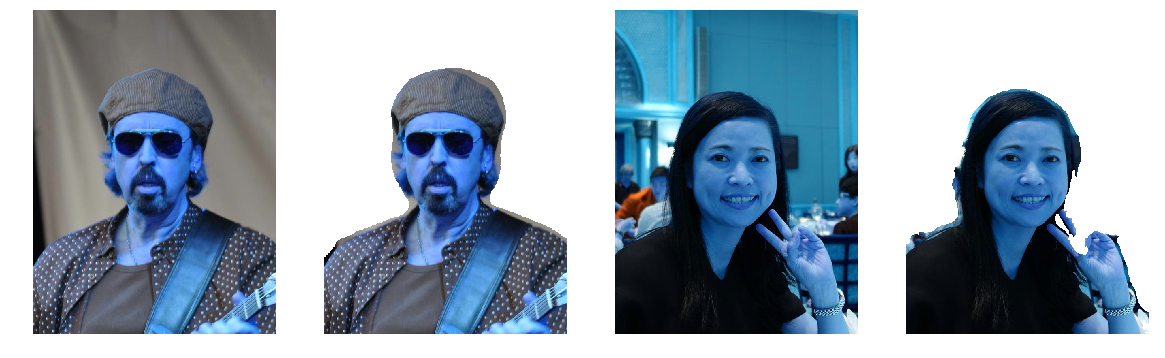

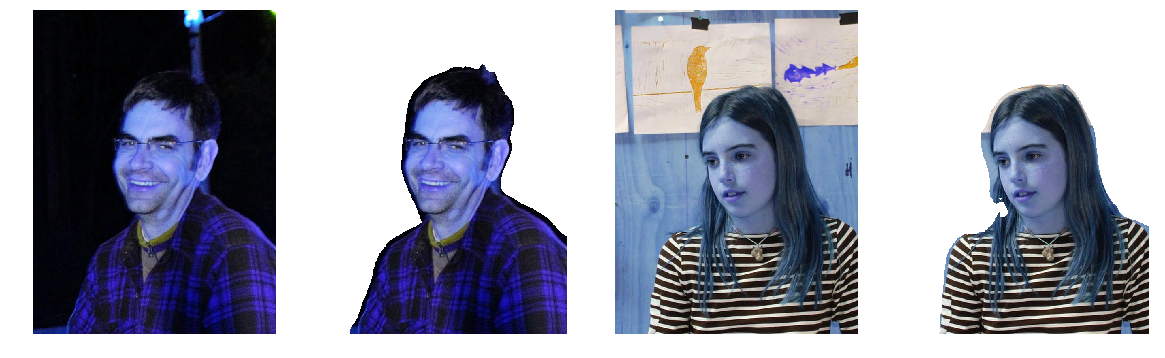

In [45]:
# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# Our subplot will contain 4 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)

# sample fname: 1803281053-00000126.png
    

# image
plt.subplot(1,4,1)
image = X_test_orig[1,:,:,:] # can also write as X_test_orig[1]
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,4,2)
mask = predicted_masks[1, :, :, :] # # can also write as preds_orig[1]
plt.imshow(mask)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test_orig[2,:,:,:]
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,4,4)
mask = predicted_masks[2, :, :, :]
plt.imshow(mask)
plt.axis('off')



# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test_orig[3,:,:,:]
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,4,2)
mask = predicted_masks[3, :, :, :]
plt.imshow(mask)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test_orig[4,:,:,:]
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,4,4)
mask = predicted_masks[4, :, :, :]
plt.imshow(mask)
plt.axis('off')

plt.show()

### Display predictions

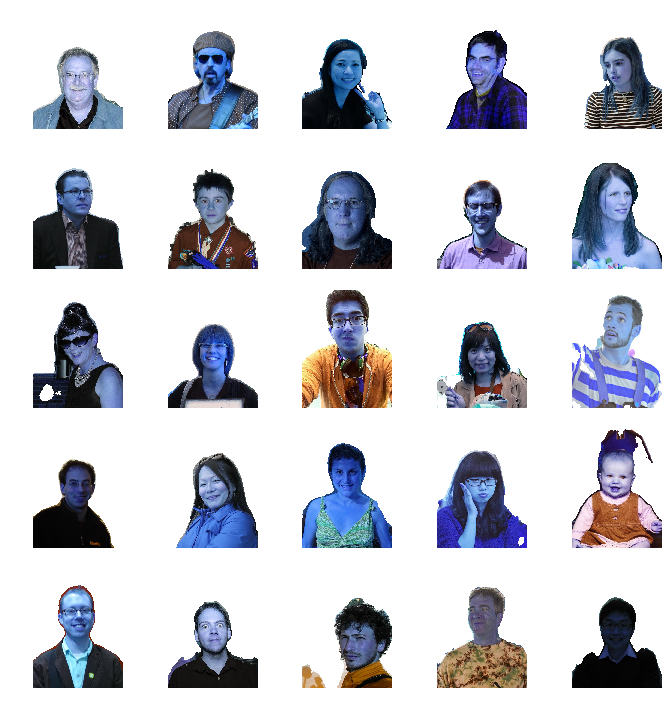

In [46]:

# predicted_masks

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(predicted_masks[i,:,:,:], cmap=plt.cm.gray)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Display original test images

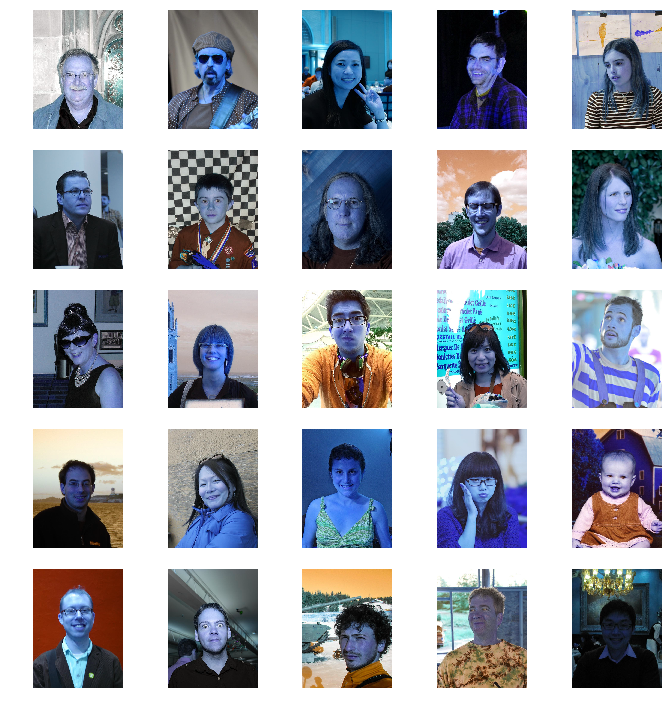

In [47]:
# preds_orig

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(X_test_orig[i,:,:,:], cmap=plt.cm.gray)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Convert the Model to Tensorflow.js

In [48]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

    100% |████████████████████████████████| 13.9MB 2.2MB/s 
    100% |████████████████████████████████| 81.4MB 543kB/s 
    100% |████████████████████████████████| 2.8MB 6.5MB/s 
    100% |████████████████████████████████| 81kB 5.1MB/s 
    100% |████████████████████████████████| 317kB 4.3MB/s 
    100% |████████████████████████████████| 51kB 18.5MB/s 
    100% |████████████████████████████████| 2.2MB 13.3MB/s 
    100% |████████████████████████████████| 3.2MB 12.3MB/s 
    100% |████████████████████████████████| 440kB 10.7MB/s 
    100% |████████████████████████████████| 102kB 24.0MB/s 
    100% |████████████████████████████████| 1.2MB 17.4MB/s 
    100% |████████████████████████████████| 51kB 20.7MB/s 
    100% |████████████████████████████████| 61kB 25.5MB/s 
    100% |████████████████████████████████| 25.2MB 1.8MB/s 
    100% |████████████████████████████████| 276kB 24.5MB/s 
    100% |████████████████████████████████| 92kB 21.2MB/s 
    100% |████████████████████████████████| 327k

In [49]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [50]:
# check that the folder containing the tfjs model files has been created
!ls

__notebook__.ipynb  df_test.csv.gz   df_val.csv.gz  tfjs
__output__.json     df_train.csv.gz  model.h5


## Reference Kernels

- Keras U-Net starter - LB 0.277<br>
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

- Simple Cell Segmentation with Keras and U-Net<br>
https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

- Python Generators to reduce RAM usage [ Part 2 ]<br>
https://www.kaggle.com/vbookshelf/python-generators-to-reduce-ram-usage-part-2


## Conclusion

This was a simple approach. To improve the quality of the segmented images you can try the following:
- training with more images
- using different loss functions 
- tuning the model parameters
- using a different model architecture

Many thanks to Laurent H. for making this interesting and high quality dataset available on Kaggle.

Thank you for reading.